# Intermediate Machine Learning

In this module, the focus will be on the following:

- design pipelines to improve the quality of your machine learning code,
- use advanced techniques for model validation (cross-validation),
- build state-of-the-art models that are widely used to win Kaggle competitions (XGBoost), and
- avoid common and important data science mistakes (leakage).



## Pipelines

Pipelines are a simple way to keep your data preprocessing and modeling code organized. Specifically, a pipeline bundles preprocessing and modeling steps so you can use the whole bundle as if it were a single step.

Main benefits of using pipeline are :
- Cleaner Code: Accounting for data at each step of preprocessing can get messy. With a pipeline, you won't need to manually keep track of your training and validation data at each step.
- Fewer Bugs: There are fewer opportunities to misapply a step or forget a preprocessing step.
- Easier to Productionize: It can be surprisingly hard to transition a model from a prototype to something deployable at scale. We won't go into the many related concerns here, but pipelines can help.

The full pipeline can be constructed in three steps:
### **Step 1**: **Define Preprocessing Steps**:
    - imputes missing values in numerical data, and
    - imputes missing values and applies a one-hot encoding to categorical data.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Read the data
data = pd.read_csv('../input/melbourne-housing-snapshot/melb_data.csv')

# Separate target from predictors
y = data.Price
X = data.drop(['Price'], axis=1)

# Divide data into training and validation subsets
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)

# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 10 and 
                        X_train_full[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = categorical_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()

In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='constant')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

### Step 2: Define the Model:
Next, we define a `random forest model` with the familiar `RandomForestRegressor` class.

In [3]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=0)

### Step 3: Create and Evaluate the Pipeline
- Finally, we use the Pipeline class to define a pipeline that bundles the preprocessing and modeling steps. There are a few important things to notice:
- With the pipeline, we preprocess the training data and fit the model in a single line of code. (In contrast, without a pipeline, we have to do imputation, one-hot encoding, and model training in separate steps. This becomes especially messy if we have to deal with both numerical and categorical variables!)
- With the pipeline, we supply the unprocessed features in X_valid to the predict() command, and the pipeline automatically preprocesses the features before generating predictions. (However, without a pipeline, we have to remember to preprocess the validation data before making predictions.)

In [4]:
from sklearn.metrics import mean_absolute_error

# Bundle preprocessing and modeling code in a pipeline
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                             ('model', model)
                            ])

# Preprocessing of training data, fit model 
my_pipeline.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = my_pipeline.predict(X_valid)

# Evaluate the model
score = mean_absolute_error(y_valid, preds)
print('MAE:', score)

MAE: 160679.18917034855


## Cross Validation

In cross-validation, we run our modeling process on different subsets of the data to get multiple measures of model quality.
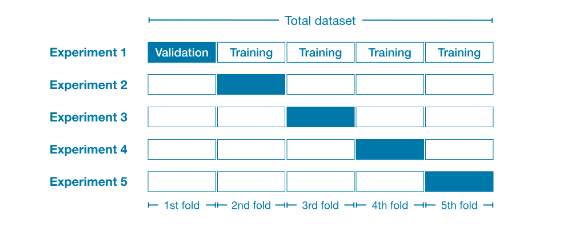

**Cross-validation** gives a more accurate measure of model quality, which is especially important if you are making a lot of modeling decisions. However, it can take longer to run, because it estimates multiple models (one for each fold).

- For small datasets, where extra computational burden isn't a big deal, you should run cross-validation.
- For larger datasets, a single validation set is sufficient. Your code will run faster, and you may have enough data that there's little need to re-use some of it for holdout.

In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
import pandas as pd

# Read the data
data = pd.read_csv('../input/melbourne-housing-snapshot/melb_data.csv')

# Select subset of predictors
cols_to_use = ['Rooms', 'Distance', 'Landsize', 'BuildingArea', 'YearBuilt']
X = data[cols_to_use]

# Select target
y = data.Price
my_pipeline = Pipeline(steps=[('preprocessor', SimpleImputer()),
                              ('model', RandomForestRegressor(n_estimators=50,
                                                              random_state=0))])



# Multiply by -1 since sklearn calculates *negative* MAE
scores = -1 * cross_val_score(my_pipeline, X, y,
                              cv=5,
                              scoring='neg_mean_absolute_error')

print("MAE scores:\n", scores)

MAE scores:
 [301628.7893587  303164.4782723  287298.331666   236061.84754543
 260383.45111427]


In [6]:
print("Average MAE score (across experiments):")
print(scores.mean())

Average MAE score (across experiments):
277707.3795913405


Using cross-validation yields a much better measure of model quality, with the added benefit of cleaning up our code.

## XGBoost

It is considered as the most accurate modeling technique for structured data.

Gradient boosting is a method that goes through cycles to iteratively add models into an ensemble.

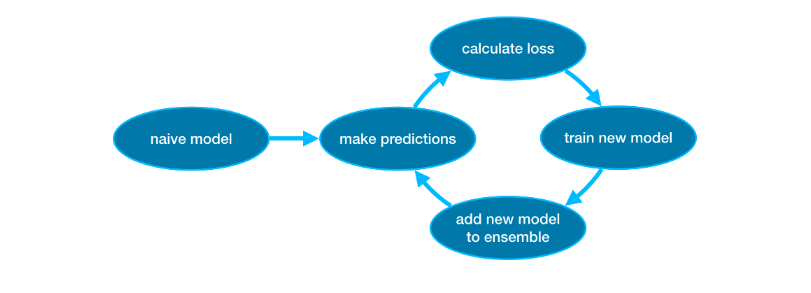

**XGBoost** stands for extreme gradient boosting, which is an implementation of gradient boosting with several additional features focused on performance and speed. (Scikit-learn has another version of gradient boosting, but XGBoost has some technical advantages.)



In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

# Read the data
data = pd.read_csv('../input/melbourne-housing-snapshot/melb_data.csv')

# Select subset of predictors
cols_to_use = ['Rooms', 'Distance', 'Landsize', 'BuildingArea', 'YearBuilt']
X = data[cols_to_use]

# Select target
y = data.Price

# Separate data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y)


my_model = XGBRegressor()
my_model.fit(X_train, y_train)


predictions = my_model.predict(X_valid)
print("Mean Absolute Error: " + str(mean_absolute_error(predictions, y_valid)))

Mean Absolute Error: 245378.67665224595


### Parameter Tuning

XGBoost have a few parameters that can be effectivily tuned to increase the accuracy and efficiency.

The main parameters are :
- n_estimators
- early_stopping_rounds
- learning_rate
- n_jobs

#### n_estimators

**n_estimators** specifies how many times to go through the modeling cycle described above. It is equal to the number of models that we include in the ensemble.
- Too low a value causes underfitting, which leads to inaccurate predictions on both training data and test data.
- Too high a value causes overfitting, which causes accurate predictions on training data, but inaccurate predictions on test data (which is what we care about).

In [8]:
my_model = XGBRegressor(n_estimators=500)
my_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

#### early_stopping_rounds

**early_stopping_rounds** offers a way to automatically find the ideal value for n_estimators. Early stopping causes the model to stop iterating when the validation score stops improving, even if we aren't at the hard stop for n_estimators. It's smart to set a high value for **n_estimators** and then use **early_stopping_rounds** to find the optimal time to stop iterating.

In [9]:
my_model = XGBRegressor(n_estimators=500)
my_model.fit(X_train, y_train, 
             early_stopping_rounds=5, 
             eval_set=[(X_valid, y_valid)],
             verbose=False)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

#### learning_rate

Instead of getting predictions by simply adding up the predictions from each component model, we can multiply the predictions from each model by a small number (known as the learning rate) before adding them in.

In general, a small learning rate and large number of estimators will yield more accurate XGBoost models, though it will also take the model longer to train since it does more iterations through the cycle. As default, XGBoost sets learning_rate=0.1


In [10]:
my_model = XGBRegressor(n_estimators=1000, learning_rate=0.05)
my_model.fit(X_train, y_train, 
             early_stopping_rounds=5, 
             eval_set=[(X_valid, y_valid)], 
             verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

#### n_jobs

On larger datasets where runtime is a consideration, you can use parallelism to build your models faster. It's common to set the parameter n_jobs equal to the number of cores on your machine. On smaller datasets, this won't help.

The resulting model won't be any better, so micro-optimizing for fitting time is typically nothing but a distraction. But, it's useful in large datasets where you would otherwise spend a long time waiting during the fit command.

In [11]:
my_model = XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=4)
my_model.fit(X_train, y_train, 
             early_stopping_rounds=5, 
             eval_set=[(X_valid, y_valid)], 
             verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=4, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

## Data Leakage

Data leakage (or leakage) happens when your training data contains information about the target, but similar data will not be available when the model is used for prediction. This leads to high performance on the training set (and possibly even the validation data), but the model will perform poorly in production.

There are two main types of leakage: **target leakage** and **train-test contamination.**

#### Target leakage

Target leakage occurs when your predictors include data that will not be available at the time you make predictions. It is important to think about target leakage in terms of the timing or chronological order that data becomes available, not merely whether a feature helps make good predictions.

#### Train-Test contamination

Recall that validation is meant to be a measure of how the model does on data that it hasn't considered before. You can corrupt this process in subtle ways if the validation data affects the preprocessing behavior. This is sometimes called train-test contamination.


In [12]:
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Read the data
data = pd.read_csv('../input/aer-credit-card-datacsv/AER_credit_card_data.csv', 
                   true_values = ['yes'], false_values = ['no'])

# Select target
y = data.card

# Select predictors
X = data.drop(['card'], axis=1)

print("Number of rows in the dataset:", X.shape[0])
X.head()



# Since there is no preprocessing, we don't need a pipeline (used anyway as best practice!)
my_pipeline = make_pipeline(RandomForestClassifier(n_estimators=100))
cv_scores = cross_val_score(my_pipeline, X, y, 
                            cv=5,
                            scoring='accuracy')

print("Cross-validation accuracy: %f" % cv_scores.mean())

Number of rows in the dataset: 1319
Cross-validation accuracy: 0.979534


In [13]:
# Drop leaky predictors from dataset
potential_leaks = ['expenditure', 'share', 'active', 'majorcards']
X2 = X.drop(potential_leaks, axis=1)

# Evaluate the model with leaky predictors removed
cv_scores = cross_val_score(my_pipeline, X2, y, 
                            cv=5,
                            scoring='accuracy')

print("Cross-val accuracy: %f" % cv_scores.mean())

Cross-val accuracy: 0.830171


As you can see, eventhough accuracy dropped a bit, it will always be consistent above 80% by preventing data leakage.